In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
root = './dataset'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = dset.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_data = dset.FashionMNIST(root=root, train=False, transform=transform, download=True)

In [5]:
from torch.utils.tensorboard import SummaryWriter

In [6]:
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [7]:
batch_size = 128
nb_epochs = 20

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [9]:
# 임의의 학습 이미지를 가져옵니다
dataiter = iter(train_loader)
images, labels = dataiter.next()
# tensorboard에 기록합니다.
img_grid = torchvision.utils.make_grid(images)
writer.add_image('four_fashion_mnist_images', img_grid)

In [10]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [11]:
class multilayer_nn(nn.Module):
    def __init__(self):
        super(multilayer_nn, self).__init__()
        
        self.layer1 = nn.Sequential(
            torch.nn.Linear(28*28,256,bias=True),
            torch.nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            torch.nn.Linear(256,128,bias=True),
            torch.nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            torch.nn.Linear(128,10,bias=True)
        )
    
    def forward(self, x):
        x = x.view(x.size(0),-1)
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        x_out = self.layer3(x_out)
        return x_out
    
def weight_init(m):
    if isinstance(m, nn.Linear):
        m.weight.data = nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))

In [12]:
model = multilayer_nn()
model.apply(weight_init)

multilayer_nn(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [13]:
writer.add_graph(model, images)
# writer.close()

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .002)

In [15]:
running_loss = 0.0
for epoch in range(nb_epochs + 1):
    for batch_idx, (X_features, labels) in enumerate(train_loader):
        X_train_bc, y_train_bc = X_features, labels
        
        prediction = model(X_train_bc)
        cost = criterion(prediction, y_train_bc)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        running_loss += cost.item()
        
        if batch_idx % 128 == 127:    
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(train_loader) + batch_idx)
            running_loss = 0.0
        if batch_idx+1 == len(train_loader):
            print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
                epoch, nb_epochs, batch_idx+1, len(train_loader), cost.item())
                 )
        

Epoch    0/20 Batch 468/468 Cost: 0.424612
Epoch    1/20 Batch 468/468 Cost: 0.470712
Epoch    2/20 Batch 468/468 Cost: 0.356639
Epoch    3/20 Batch 468/468 Cost: 0.241629
Epoch    4/20 Batch 468/468 Cost: 0.214392
Epoch    5/20 Batch 468/468 Cost: 0.263465
Epoch    6/20 Batch 468/468 Cost: 0.315669
Epoch    7/20 Batch 468/468 Cost: 0.319922
Epoch    8/20 Batch 468/468 Cost: 0.263592
Epoch    9/20 Batch 468/468 Cost: 0.307562
Epoch   10/20 Batch 468/468 Cost: 0.170886
Epoch   11/20 Batch 468/468 Cost: 0.364084
Epoch   12/20 Batch 468/468 Cost: 0.198143
Epoch   13/20 Batch 468/468 Cost: 0.280657
Epoch   14/20 Batch 468/468 Cost: 0.187322
Epoch   15/20 Batch 468/468 Cost: 0.176889
Epoch   16/20 Batch 468/468 Cost: 0.199999
Epoch   17/20 Batch 468/468 Cost: 0.093671
Epoch   18/20 Batch 468/468 Cost: 0.165043
Epoch   19/20 Batch 468/468 Cost: 0.158326
Epoch   20/20 Batch 468/468 Cost: 0.225501


In [14]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs, labels
        outputs = model(imgs)
        _, argmax = torch.max(outputs, 1)
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))    

Accuracy for 9984 images: 87.66%


In [15]:
y_pred, y_true = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.float(), y       # beware that input to embedding should be type 'long'
        outputs = F.softmax(model(x)).max(1)[-1]       # predicted label
        y_true += list(y.cpu().numpy())                # true label
        y_pred += list(outputs.cpu().numpy())

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [16]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(y_true, y_pred)

0.8766025641025641

In [17]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1000
           1       0.98      0.98      0.98       997
           2       0.80      0.80      0.80       999
           3       0.86      0.90      0.88       999
           4       0.80      0.82      0.81       999
           5       0.97      0.92      0.95       997
           6       0.71      0.67      0.69       999
           7       0.94      0.94      0.94       999
           8       0.95      0.97      0.96       997
           9       0.92      0.97      0.94       998

    accuracy                           0.88      9984
   macro avg       0.88      0.88      0.88      9984
weighted avg       0.88      0.88      0.88      9984



In [20]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

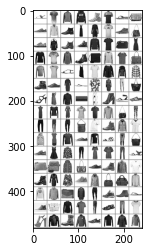

In [21]:
# 임의의 학습 이미지를 가져옵니다
dataiter = iter(train_loader)
images, labels = dataiter.next()
# tensorboard에 기록합니다.
writer.add_image('four_fashion_mnist_images', img_grid)

In [37]:
images.shape

torch.Size([128, 1, 28, 28])

In [39]:
writer.add_graph(multilayer_nn(), images)
writer.close()